
# Spot resources Analytics

Here we perform some initial process and analysis on the dataset.

---




With static dataset, e.g. load the grabbed data.

In [ ]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
%matplotlib inline


# parse the data file and extra the results
filename = 'data1'

df = pd.read_csv(filename, sep="\t", header = None)
df.columns = ["info", "SpotPrice", "TimeStamp", "InstanceType", "OS type", "AvailabilityZone"]
df['TimeStamp'] =pd.to_datetime(df.TimeStamp)

df.index = df.TimeStamp
df = df.drop('info', 1).drop(['OS type'],axis=1)
df = df.drop(['TimeStamp'],axis=1).sort_index()
 

df.head(15)

In [ ]:
print (df['InstanceType'].unique())
print (df['AvailabilityZone'].unique())

In [ ]:
instance_types  = ['c3.xlarge', 'c3.2xlarge', 'c3.4xlarge', 'c3.8xlarge']
region = 'us-east-1'

df1 = df[df.AvailabilityZone == 'us-west-1a']
df2 = df1[df1.InstanceType == 'c3.8xlarge']
df2.to_csv('us-east-1a_c3-8xlarge.csv')

In [ ]:
for k, g in df1.sort_index(ascending=True).groupby(['InstanceType'], as_index=False):
    for key, grp in g.groupby(['AvailabilityZone'], as_index=False):
        plt.figure(figsize=(15,5))
        plt.plot(grp.index, grp['SpotPrice'], label=key)
        
    plt.legend()
    plt.title('Spot Pricing - ' + k)
    plt.show()


In [ ]:
for k, g in df1.sort_index(ascending=True).groupby(['InstanceType'], as_index=False):
    #plt.figure(1, figsize(20,5))
    for key, grp in g.groupby(['AvailabilityZone'], as_index=False):
        plt.figure(figsize=(15,5))
        plt.hist(grp['SpotPrice'], bins=100, label=key,)
        plt.xlim([0, 1])
        #grp.groupby(grp.index.dayofweek).agg(['mean']).plot()
    plt.legend()
    plt.title('Histogram of Spot Pricing - ' + k)
    plt.show()

Now we grad dataset from AWS.

In [ ]:
instance_types  = ['c3.xlarge', 'c3.2xlarge', 'c3.4xlarge', 'c3.8xlarge']
region = 'us-east-1'
number_of_days = 10

end = !date -u "+%Y-%m-%dT%H:%M:%S"
end = end[0]
start = !date -v-{number_of_days}d -u "+%Y-%m-%dT%H:%M:%S"

#start = !date -v-{number_of_days}d" -u "+%Y-%m-%dT%H:%M:%S"
#print(start)
start = start[0]
print ("will process from " + start + " to " + end)


In [ ]:
import sys
import boto as boto
import boto.ec2 as ec2
import datetime, time
#import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style', 'default')  # Make the graphs a bit prettier
%pylab inline
%matplotlib inline

ec2 = boto.ec2.connect_to_region(region)


#
# process the output and convert to a dataframe
#

l = []
for instance in instance_types:
    sys.stdout.write("*** processing " + instance + " ***\n")
    sys.stdout.flush()
    prices = ec2.get_spot_price_history(start_time=start, end_time=end, instance_type=instance)
    for price in prices:
        d = {'InstanceType': price.instance_type, 
             'AvailabilityZone': price.availability_zone, 
             'SpotPrice': price.price, 
             'Timestamp': price.timestamp}
        l.append(d)
    next = prices.next_token
    while (next != ''):
        sys.stdout.write(".")
        sys.stdout.flush()
        prices = ec2.get_spot_price_history(start_time=start, end_time=end, instance_type=instance,
                                            next_token=next )
        for price in prices:
            d = {'InstanceType': price.instance_type, 
                 'AvailabilityZone': price.availability_zone, 
                 'SpotPrice': price.price, 
                 'Timestamp': price.timestamp}
            l.append(d)
        next = prices.next_token
        
    sys.stdout.write("\n")

df = pd.DataFrame(l)
df = df.set_index(pd.to_datetime(df['Timestamp']))

## Hypothesis #1
**Problems:** Can we predict future price of a spot instance given previous history and how other vm’s are reacting?

To achieve the goal of prediction, we are expecting to do pattern matching from the collected dataset. In this case, whenever users make a bid, we can based on the resources types, time or day, and the trending price to do pattern matching. We will be able to provide a prediction if we can shoot a pattern.

Expecting tools are supervised and unsupervised learning algorithms, e.g. classification and
clustering methods.



## Hypothesis #2

For each machine type there exists a region that is more favorable to use, as the market volatility is very low and the prices tend to stay cheaper than the other regions.

With in proving this hypothesis users will be able to find the best region they should be bidding in, as long as latency is not an issue for them.

Data Science tools & Techniques: We can use clustering and classification methods.


In [228]:
print (df.index.min())
print (df.index.max())
print(df.index.max()- df.index.min()) 
#df = df.truncate(before='2015-01-16', after='2015-3-18')

2015-01-17 08:01:54
2015-03-19 07:42:11
60 days 23:40:17


In [ ]:
df = df.resample('H')
df = df.fillna("ffill")

In [ ]:
#Create full time series and fill data
dfSorted = df.groupby(['AvailabilityZone', 'InstanceType'])
dfSorted = dfSorted.resample('H')
dfSorted = dfSorted.fillna("ffill")

dfSorted=dfSorted.drop('InstanceType', axis=1).drop('AvailabilityZone', axis=1)

dfSorted.to_csv("im.csv")
depa = pd.read_csv("im.csv")
depa = depa.groupby(['AvailabilityZone', 'InstanceType'])


In [269]:
#grouped_prices = [group['SpotPrice'].tolist() for name, group in depa]

#dfer = dataframe
d = {}

count = 0
#need to run through and get rid of rows where timestamp, spotprice data doesnt exist for the others
for name, group in depa:
    if count == 0:
        d['TimeStamp']=group['TimeStamp'].tolist()
    if name[0] =="ap-northeast-1a":
        for a in d['TimeStamp']+group['TimeStamp'].tolist():
            if(a not in d['TimeStamp']):
                group = group[group['TimeStamp'] != a]
                print (a)
            if(a not in group['TimeStamp'].tolist()):
                d['TimeStamp'].remove(a)
                print (a)
    
    
    #seter = set(d['TimeStamp']) - set(group['TimeStamp'].tolist())
    #print(seter)
    #remove = list(seter)
    #print(remove)    
#dfer = pd.DataFrame(d)
    
#for name, group in depa:
     #print(len(group['SpotPrice'].tolist()))
        
'''
for name, group in depa:
    if name[0] =="ap-northeast-1a":
        #group.index = group['TimeStamp']
        #print(group.head(20))
        #group = group.truncate(before='2015-01-18', after='2015-3-17')
        d[name[1]]=group['SpotPrice'].tolist()
        print(len(group['SpotPrice'].tolist()))
'''

'\nfor name, group in depa:\n    if name[0] =="ap-northeast-1a":\n        #group.index = group[\'TimeStamp\']\n        #print(group.head(20))\n        #group = group.truncate(before=\'2015-01-18\', after=\'2015-3-17\')\n        d[name[1]]=group[\'SpotPrice\'].tolist()\n        print(len(group[\'SpotPrice\'].tolist()))\n'

In [ ]:
#numpy.corrcoef(grouped_prices)

grouped_prices.corr()
'''
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
seaborn.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
# Show the plot we reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()
'''


# Hypothesis #3

There exists some kind of relation between what kind of virtual machines are turning into hotspots. Say that we establish a line as half price of EC2 instances, it makes sense to pay half price to gain usage of resources but probably not more than 3⁄4. By extracting patterns from the price history, we can study that whether or not there was the case that some resources were becoming hotspot in the spot instances market.

Potential data science method for this one includes: Time Series, Linear Regression


In [ ]:
df = pd.read_csv('us-east-1a_c3-8xlarge.csv')
#df.head(400)
df = df2
df.describe()

df.SpotPrice.plot(label='Spot Price of c3.8xlarge', figsize = (15,5))
plt.legend(loc='best')

In [ ]:
df.head(15)

# Time Series Clustering

## Time series clustering on spot market price data set.

Here we will be using TSC to analyse relations between various of types of machines and find out relationships from our clustering results.

The first step is to work out an appropriate distance/similarity metric. Secondly, we will use existing clustering techniques, such as k-means, hierarchical clustering, density-based clustering or subspace clustering, to find clustering structures.

Dynamic Time Warping (DTW) finds optimal alignment between two time series, and DTW distance is used as a distance metric in the example below.




A data set of Synthetic Control Chart Time Series is used here, which contains 600 examples of control charts. Each control chart is a time series with 60 values. There are six classes: 1) 1-100 Normal, 2) 101-200 Cyclic, 3) 201-300 Increasing trend, 4)301-400 Decreasing trend, 5) 401-500 Upward shift, and 6) 501-600 Downward shift. The dataset is downloadable at UCI KDD Archive.

In [4]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
%matplotlib inline


# parse the data file and extra the results
filename = 'aws-spot-price-history/data-1397804701'

df = pd.read_csv(filename, sep="\t", header = None)
df.columns = ["info", "SpotPrice", "TimeStamp", "InstanceType", "OS type", "AvailabilityZone"]
df['TimeStamp'] =pd.to_datetime(df.TimeStamp)

df.index = df.TimeStamp
df = df.drop(['TimeStamp'],axis=1).drop('info', 1).sort_index()


df.head(15)
#df['SpotPrice'].describe()

,SpotPrice,InstanceType,OS type,AvailabilityZone
TimeStamp,,,,
2014-02-16 00:54:00,0.0100,m1.small,Linux/UNIX,us-west-1a
2014-02-16 00:55:30,2.7320,c3.8xlarge,Linux/UNIX,us-west-1a
2014-02-16 00:58:09,0.0679,m3.large,Linux/UNIX,us-west-1b
2014-02-16 00:59:56,3.0240,c3.8xlarge,Linux/UNIX,ap-southeast-2a
2014-02-16 01:17:30,0.0224,m3.medium,Linux/UNIX,us-east-1d
2014-02-16 01:17:37,0.0100,m1.small,Linux/UNIX,us-west-1b
2014-02-16 01:24:19,0.7561,c3.2xlarge,Linux/UNIX,ap-southeast-2b
2014-02-16 01:24:19,0.7561,c3.2xlarge,Linux/UNIX,ap-southeast-2a
2014-02-16 01:24:25,0.0926,m3.xlarge,Linux/UNIX,ap-southeast-2b


In [5]:
instance_types  = ['c3.xlarge', 'c3.2xlarge', 'c3.4xlarge', 'c3.8xlarge']
region = 'us-east-1'

df1 = df[df.AvailabilityZone == 'us-west-1a']
df2 = df1[df1.InstanceType == 'c3.8xlarge']
df2.to_csv('us-east-1a_c3-8xlarge.csv')

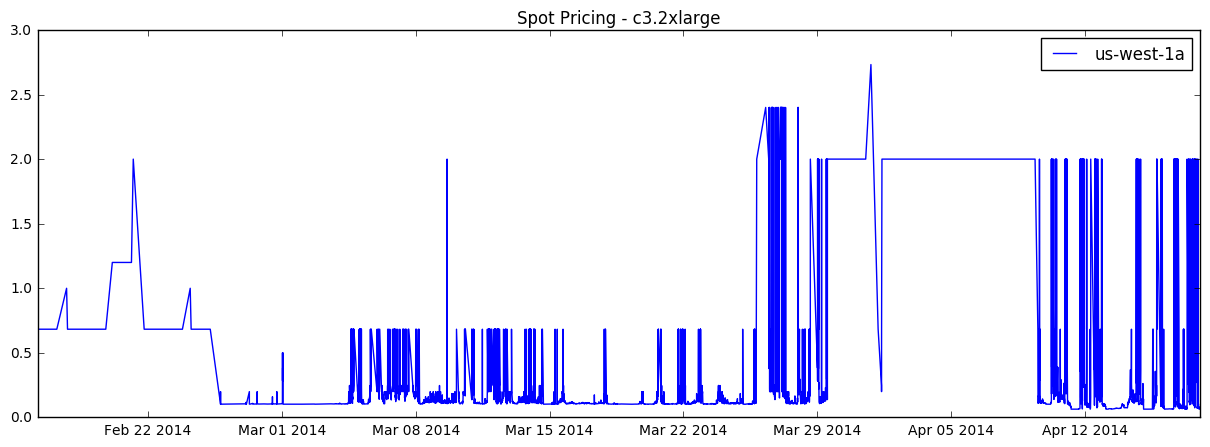

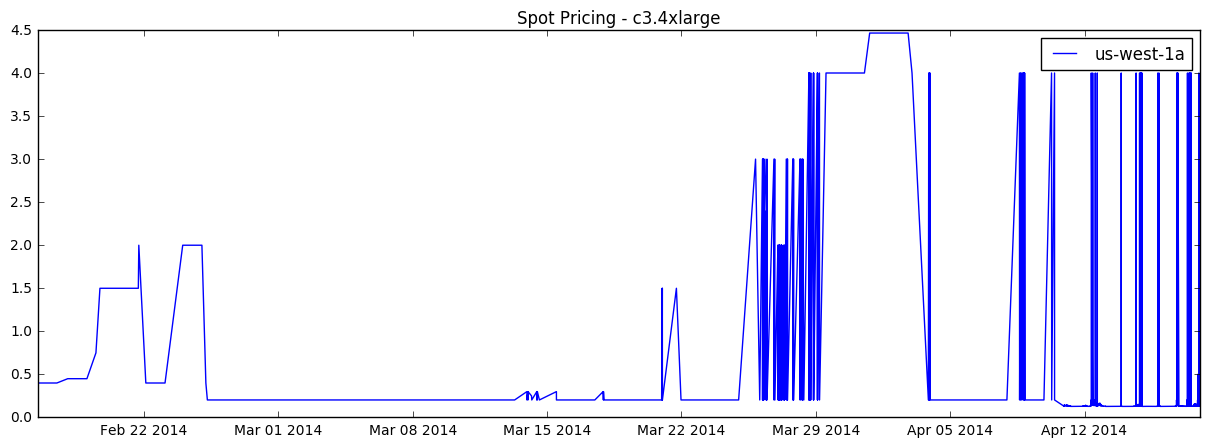

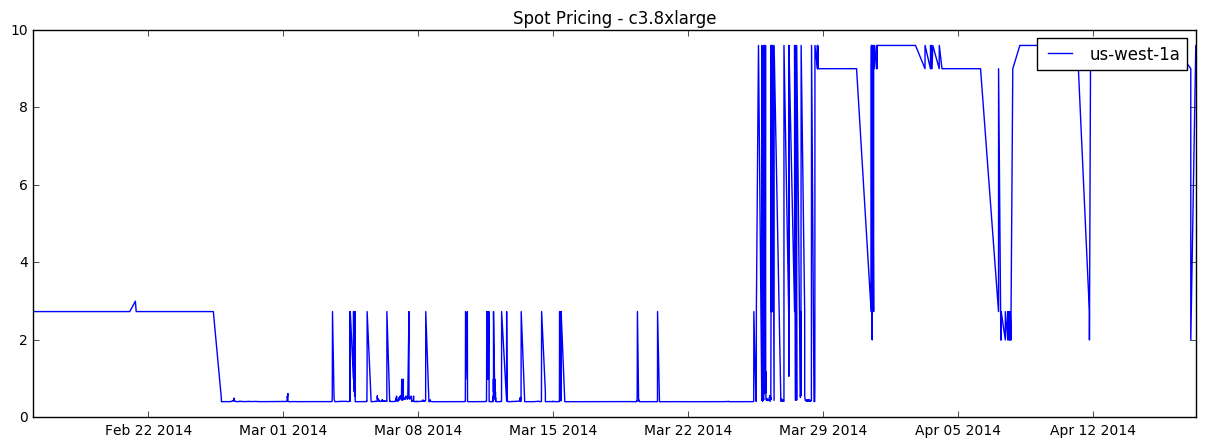

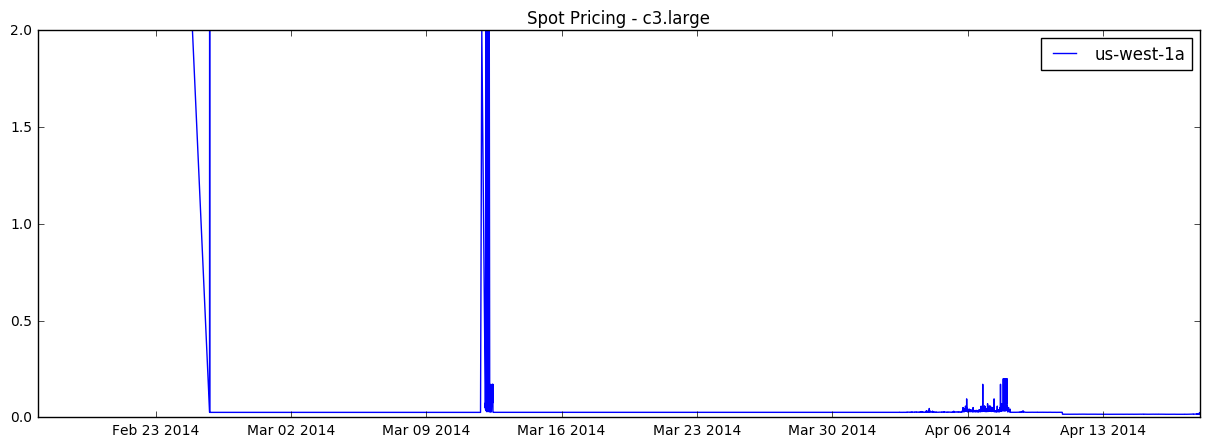

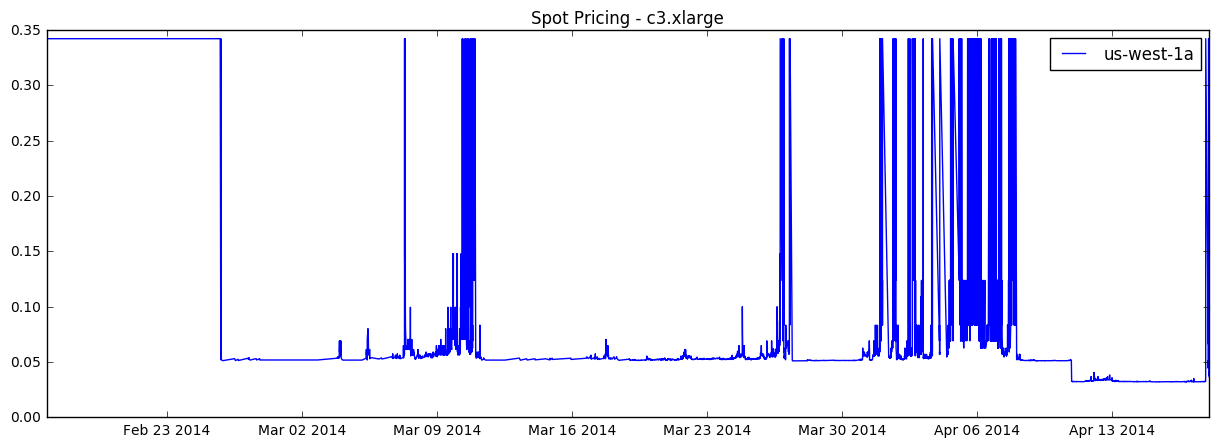

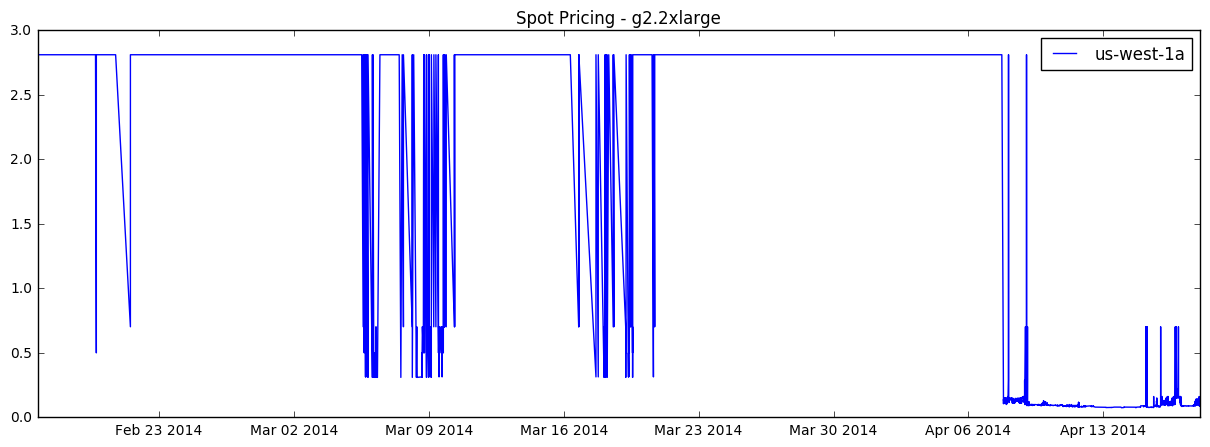

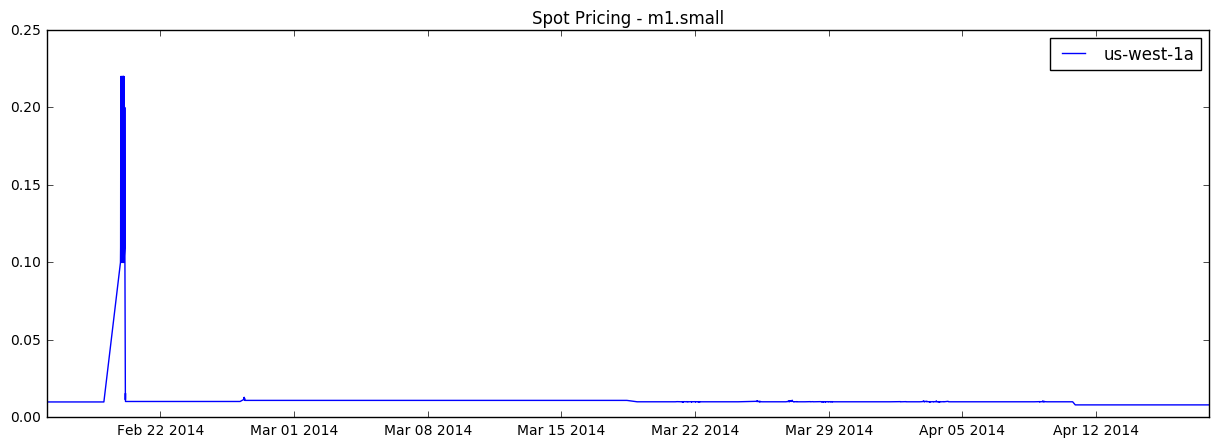

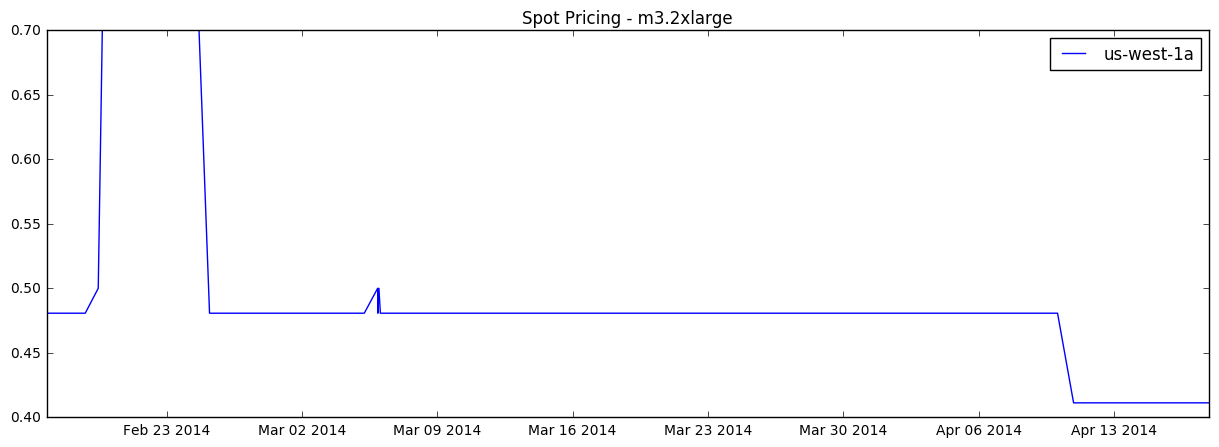

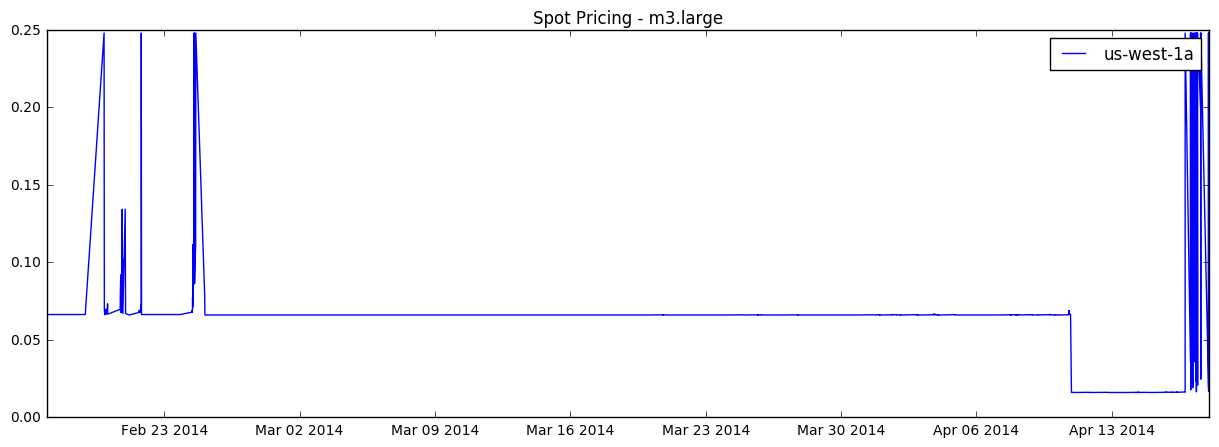

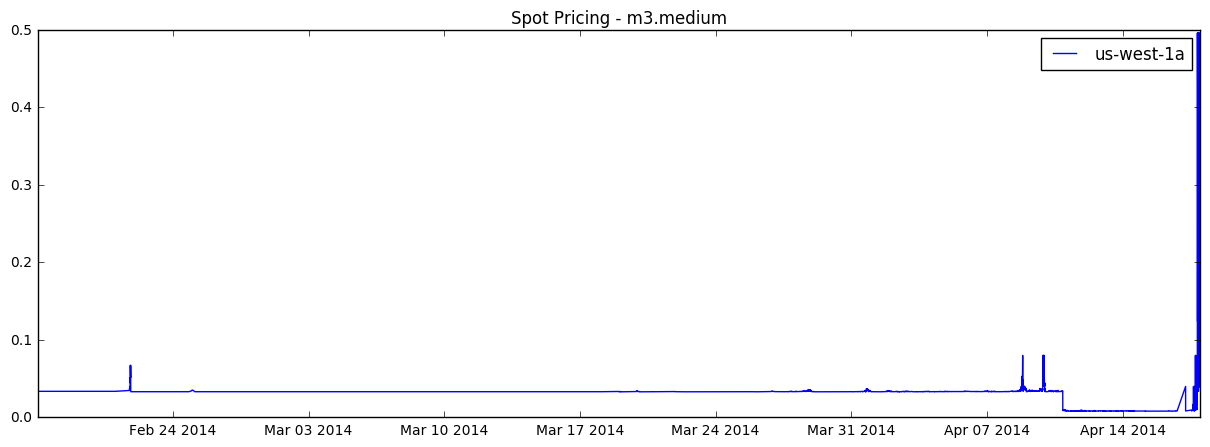

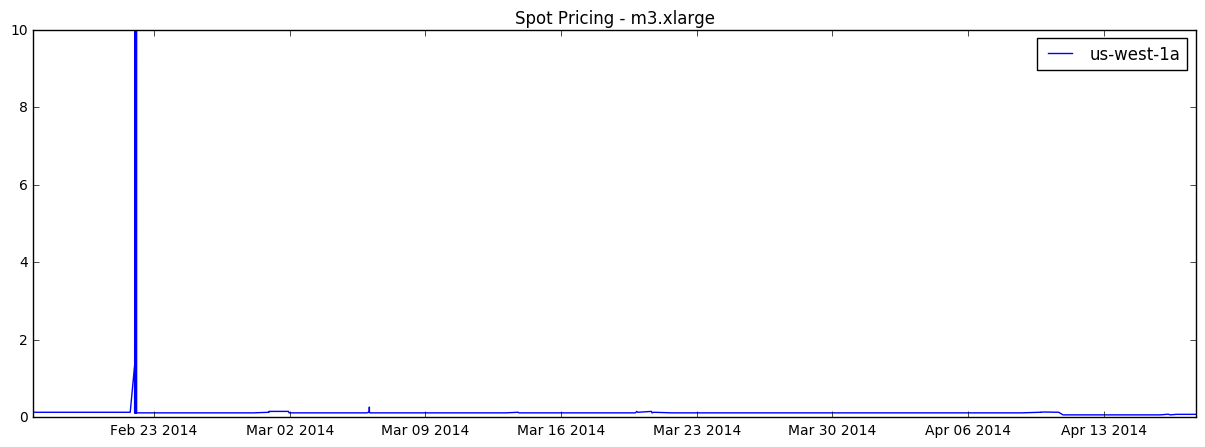

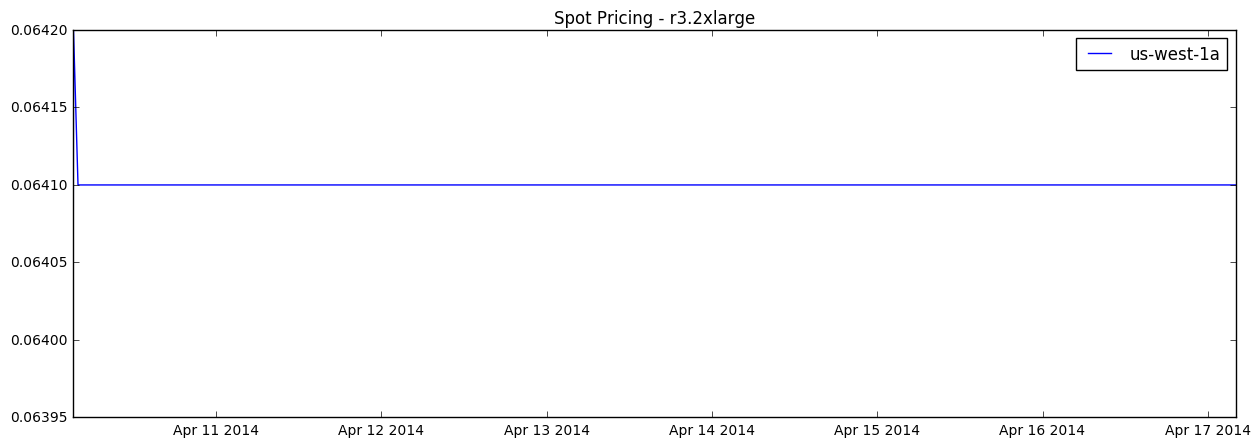

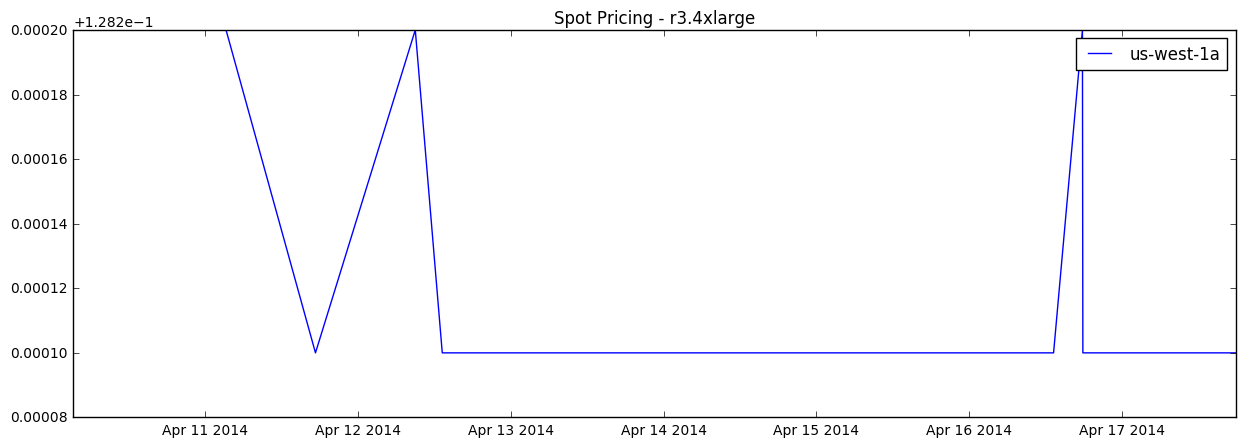

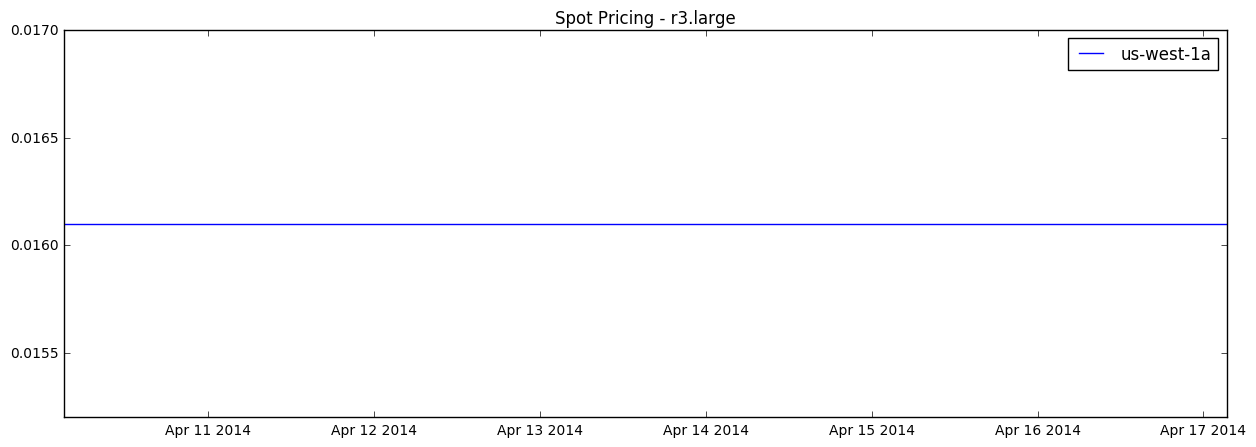

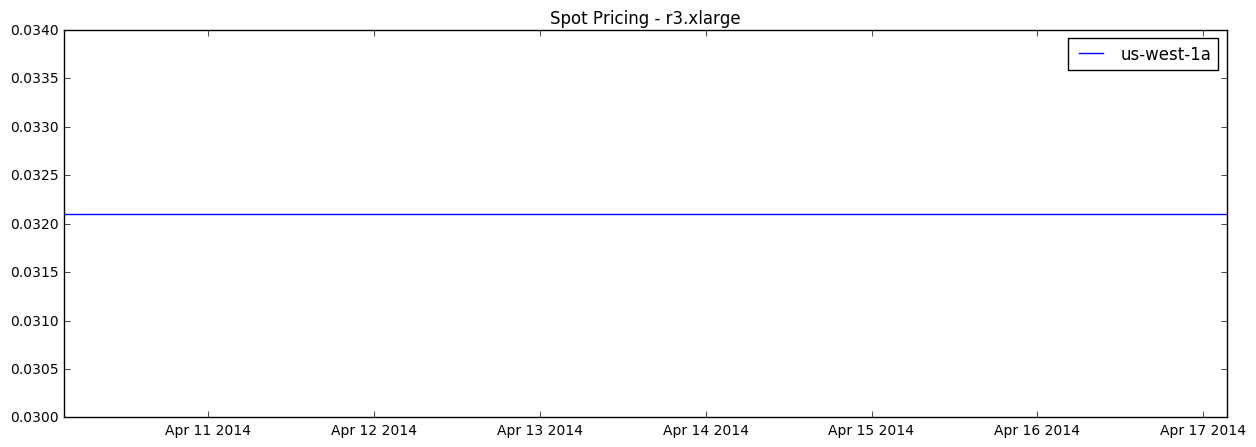

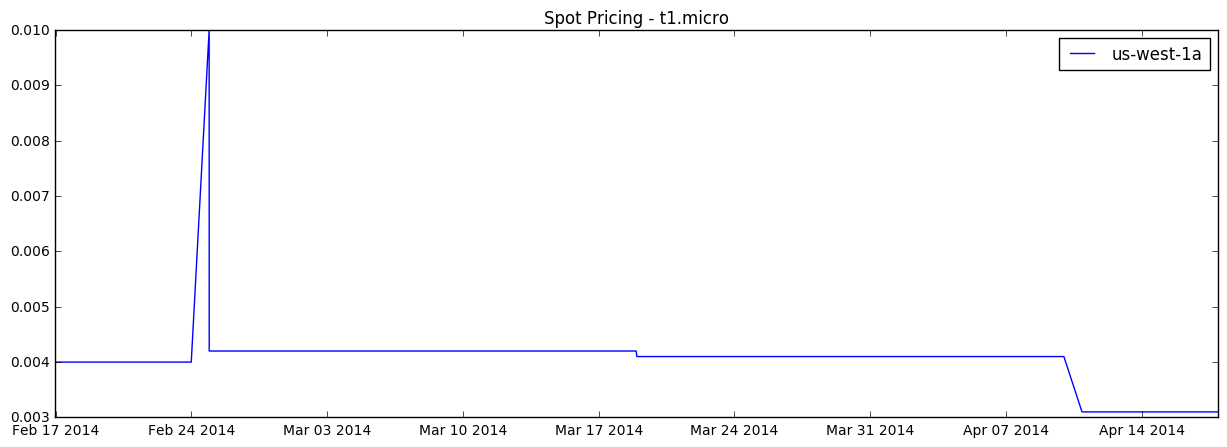

In [6]:
for k, g in df1.sort_index(ascending=True).groupby(['InstanceType'], as_index=False):
    for key, grp in g.groupby(['AvailabilityZone'], as_index=False):
        plt.figure(figsize=(15,5))
        plt.plot(grp.index, grp['SpotPrice'], label=key)
        
    plt.legend()
    plt.title('Spot Pricing - ' + k)
    plt.show()

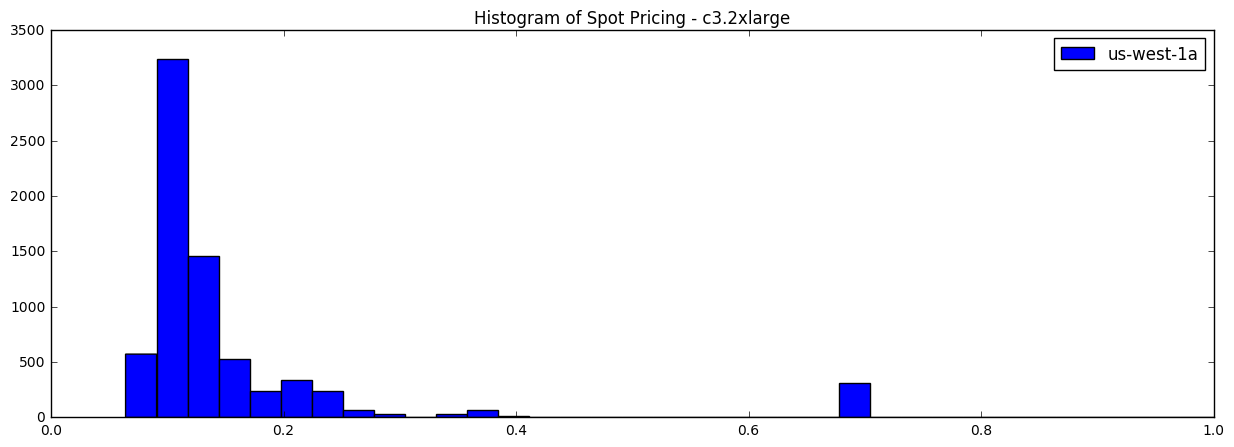

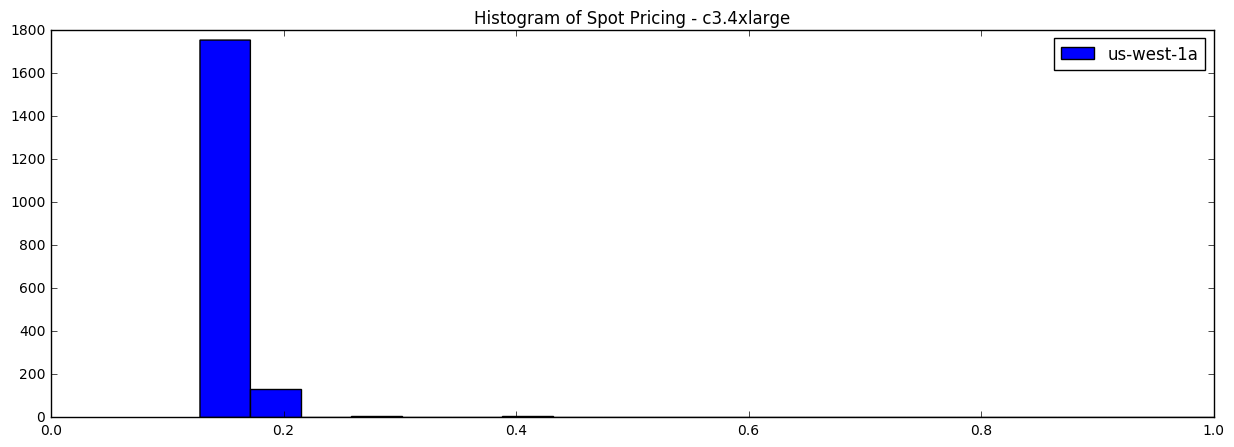

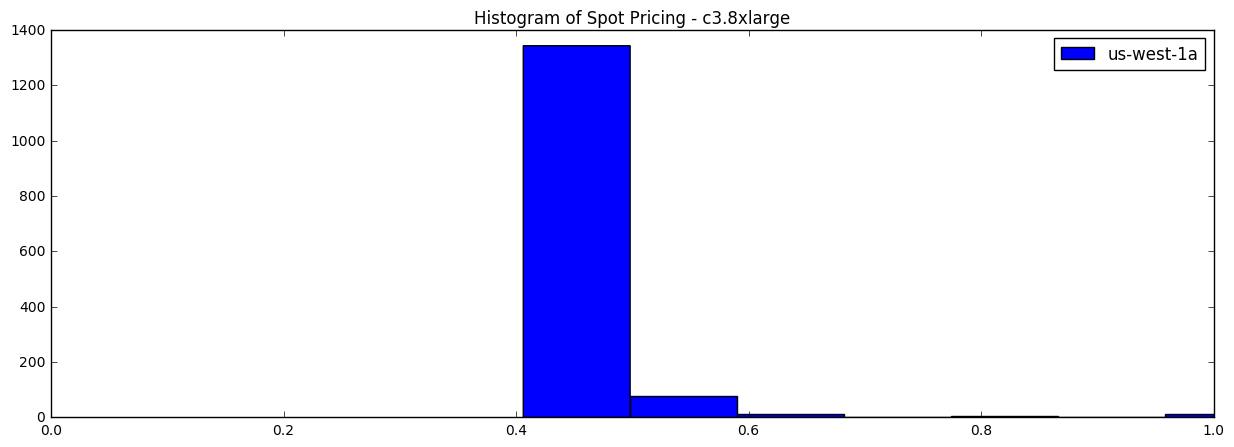

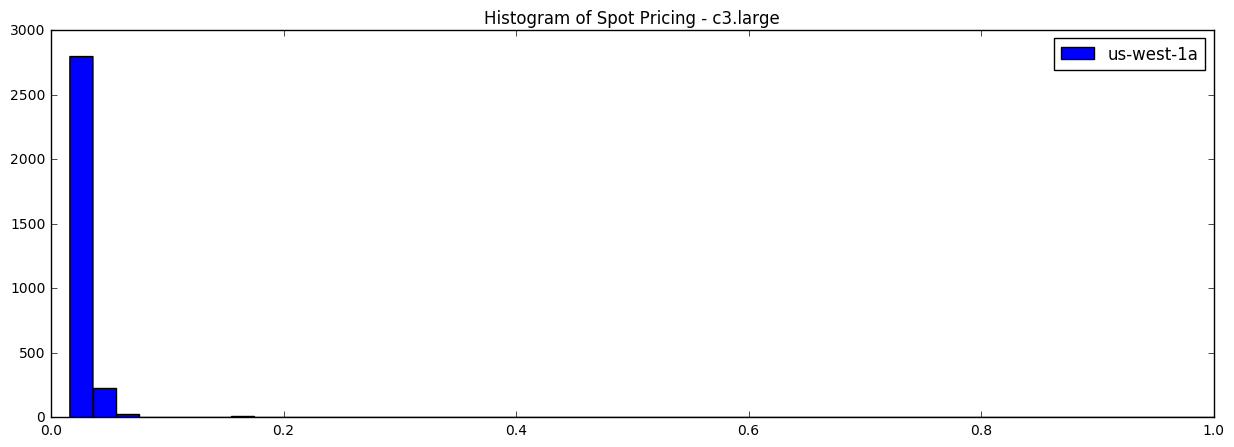

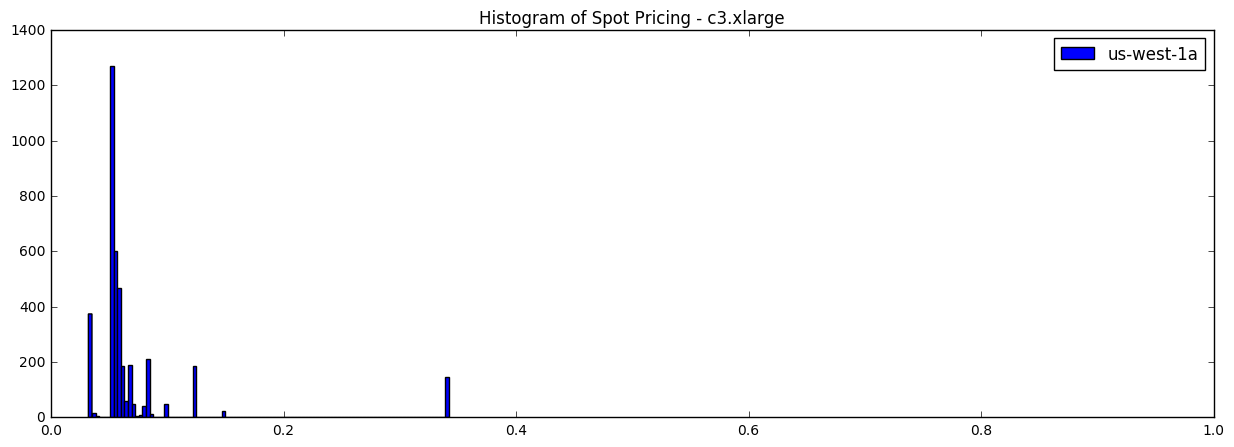

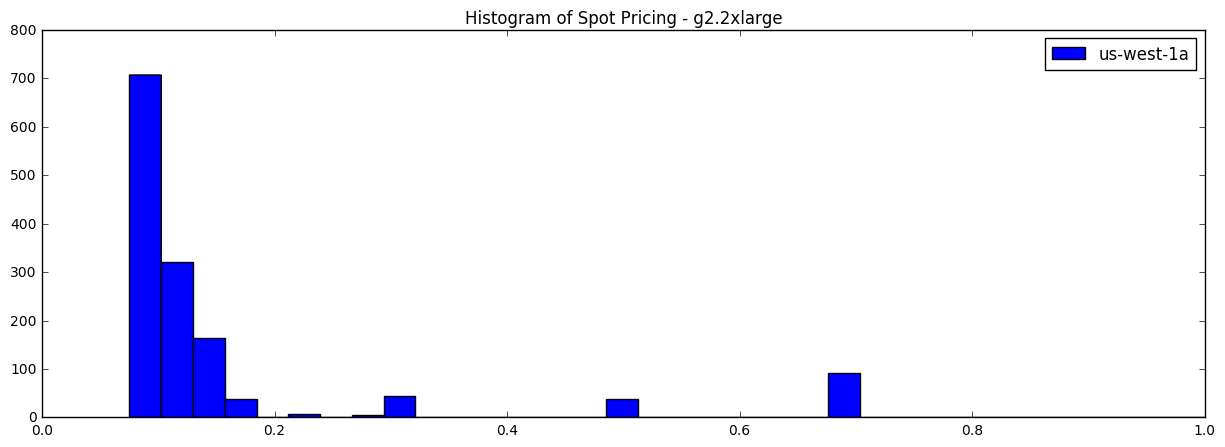

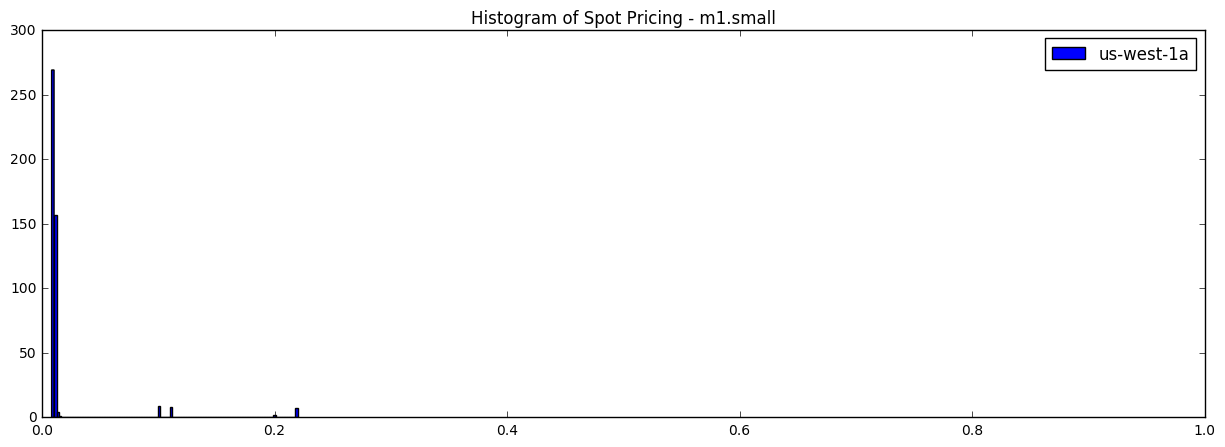

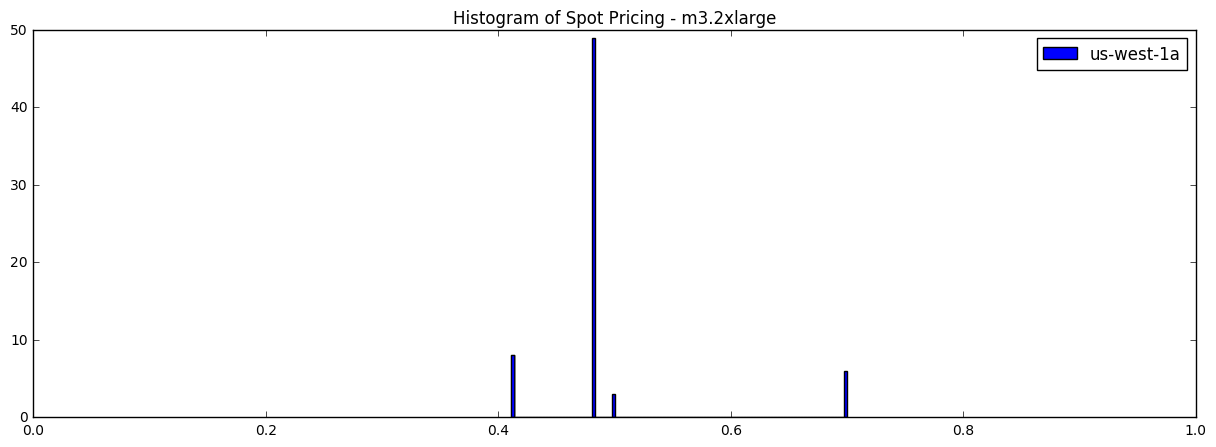

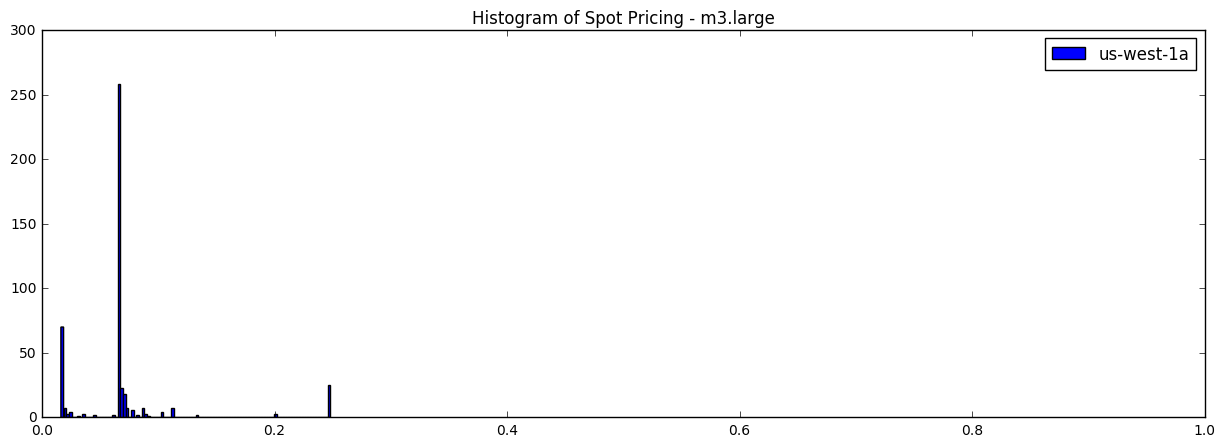

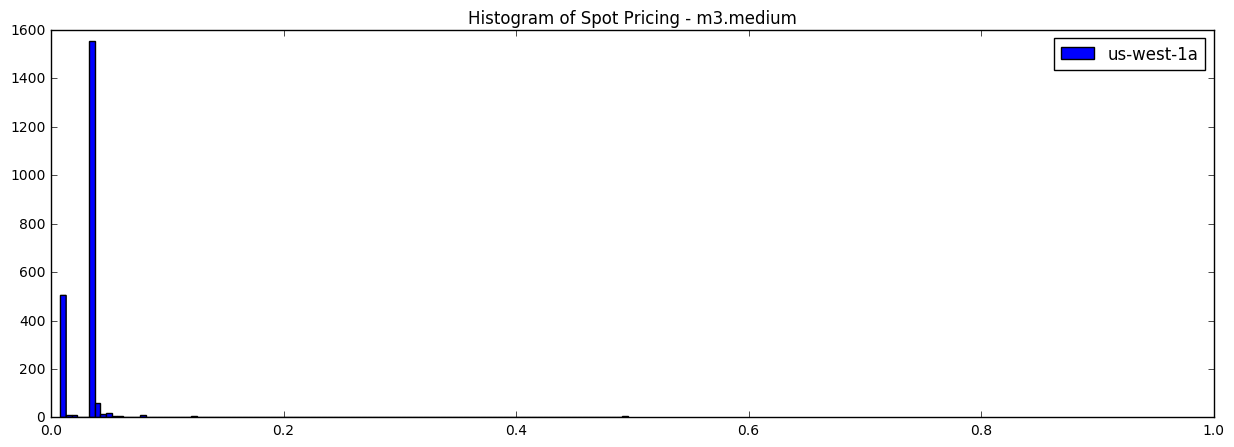

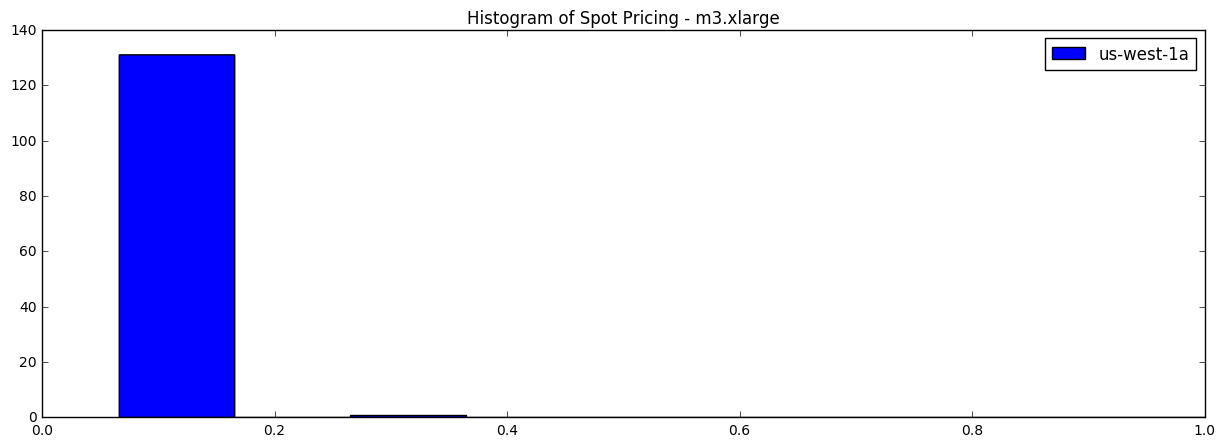

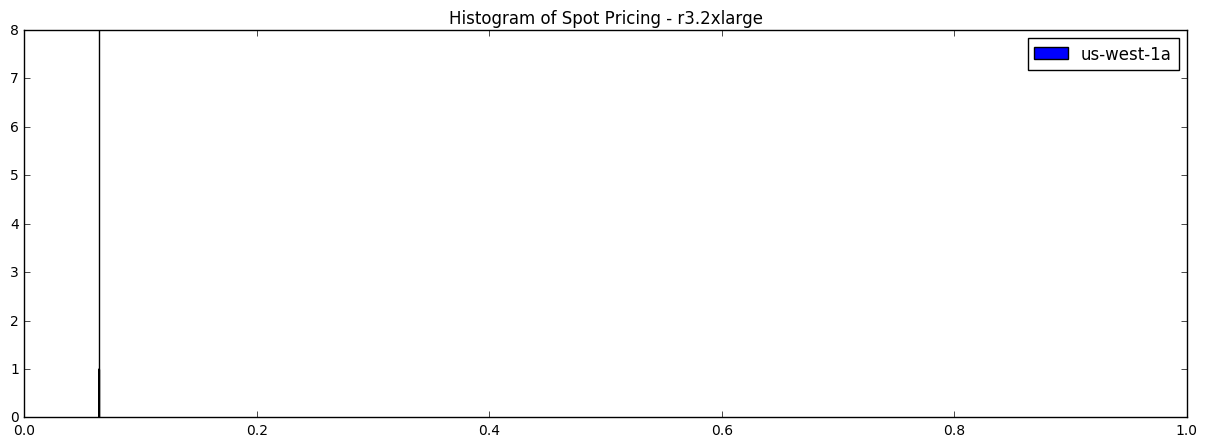

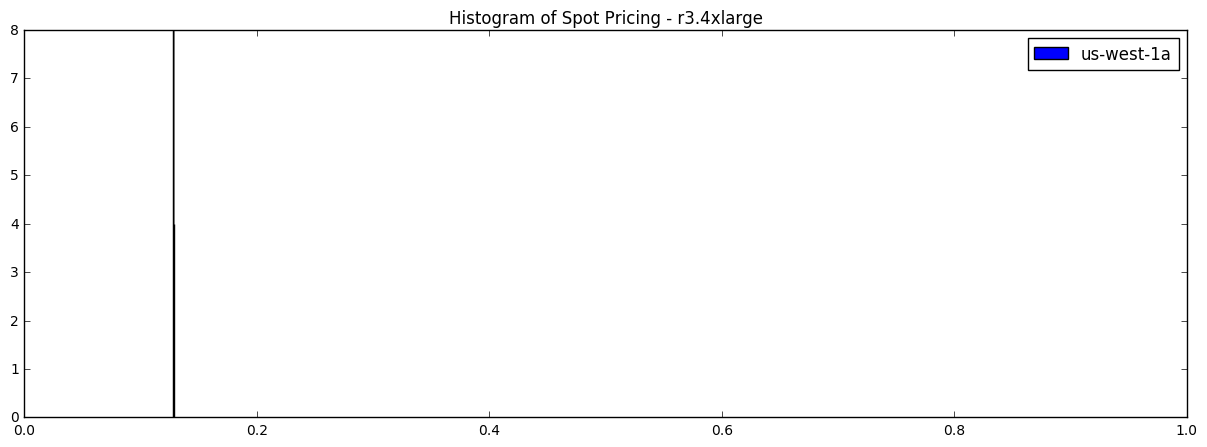

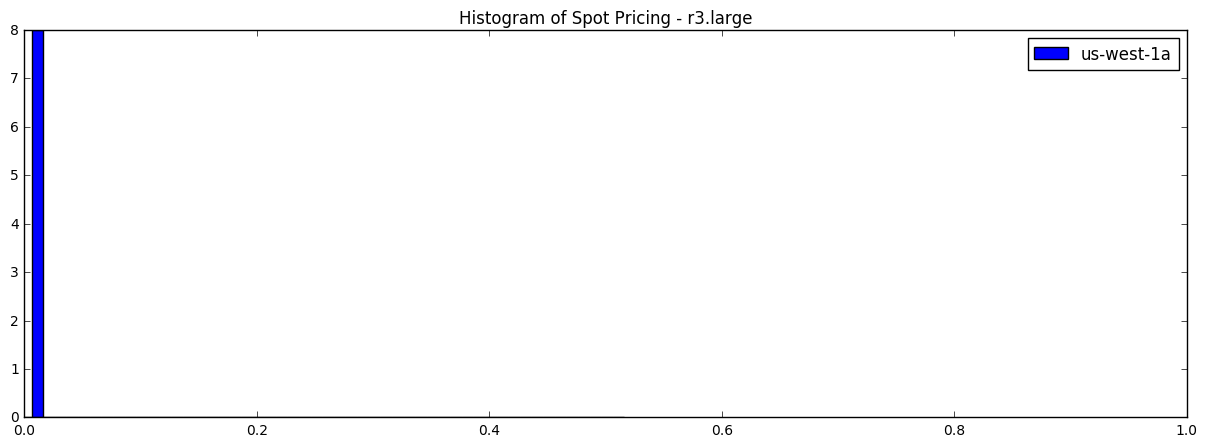

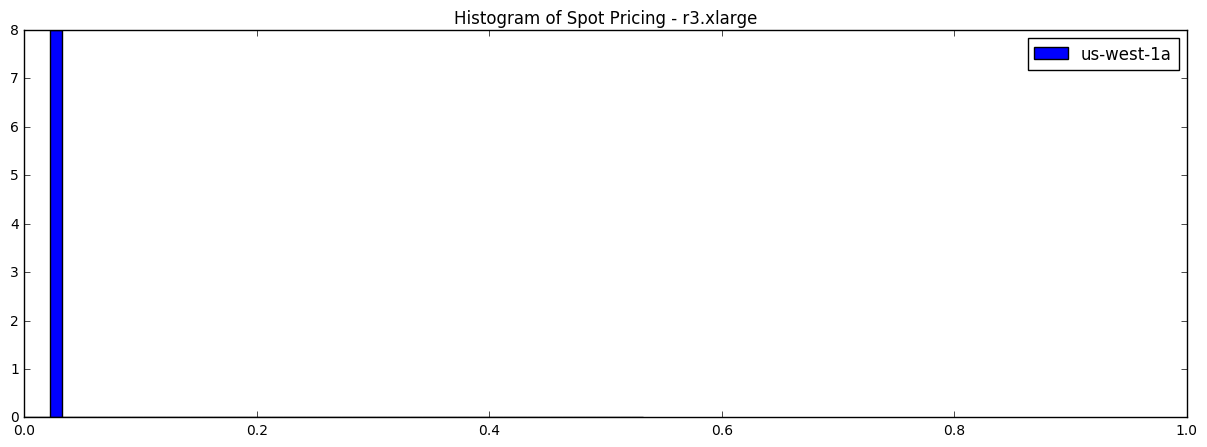

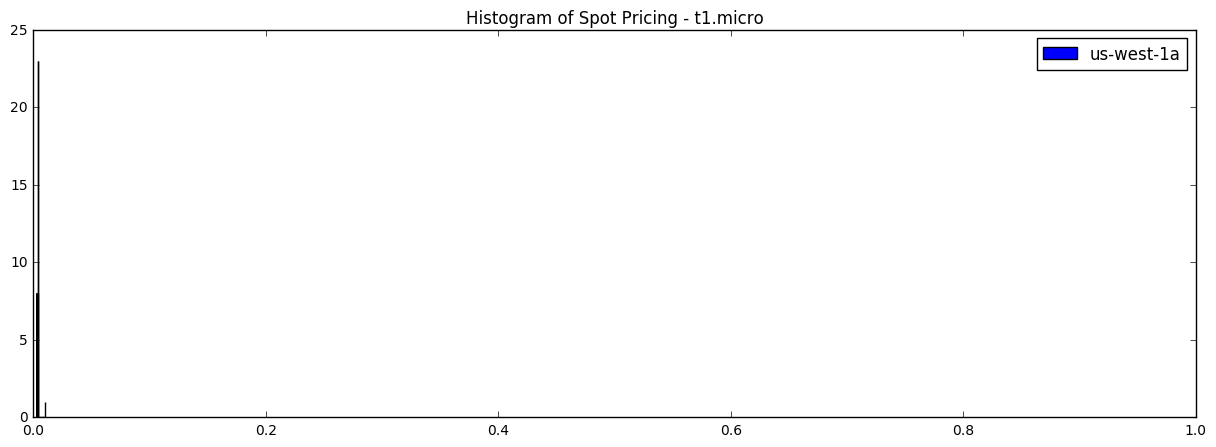

In [7]:
for k, g in df1.sort_index(ascending=True).groupby(['InstanceType'], as_index=False):
    #plt.figure(1, figsize(20,5))
    for key, grp in g.groupby(['AvailabilityZone'], as_index=False):
        plt.figure(figsize=(15,5))
        plt.hist(grp['SpotPrice'], bins=100, label=key,)
        plt.xlim([0, 1])
        #grp.groupby(grp.index.dayofweek).agg(['mean']).plot()
    plt.legend()
    plt.title('Histogram of Spot Pricing - ' + k)
    plt.show()

### Reference:
1. [Mining Time-series with Trillions of Points: Dynamic Time Warping at scale](http://practicalquant.blogspot.com/2012/10/mining-time-series-with-trillions-of.html)
2. [sackoverflow post](http://stackoverflow.com/questions/34940808/hierarchical-clustering-of-time-series-in-python-scipy-numpy-pandas)
3. [scilearn material](http://scikit-learn.org/stable/modules/clustering.html)
4. [pattern matching over time series data](http://stats.stackexchange.com/questions/136091/sequential-pattern-matching-in-time-series-data)